<a href="https://colab.research.google.com/github/changyuhsin1999/WBC-Differential-Learning-Tool/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "WBC-Differential-Learning-Tool" # Enter repo name
git_path = 'https://github.com/changyuhsin1999/WBC-Differential-Learning-Tool.git'
!git clone "{git_path}"

Cloning into 'WBC-Differential-Learning-Tool'...
remote: Enumerating objects: 991, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 991 (delta 7), reused 103 (delta 2), pack-reused 873
Receiving objects: 100% (991/991), 10.50 MiB | 2.07 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
import urllib.request
import zipfile

In [38]:
data_file = "/content/WBC-Differential-Learning-Tool/data"

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)


torch:  2.0 ; cuda:  cu118


In [39]:
train_percentage = 0.6
val_percentage = 0.15
test_percentage = 0.25

batch_size = 8
num_workers = 2

In [44]:
def define_transforms():
    """
    Define transformations for training, validation, and test data.
    For training data we will do resize to 224 * 224, randomized horizontal flipping, rotation, lighting effects, and normalization. 
    For test and val set we will do only center cropping to get to 224 * 224 and normalization
    """
    data_transforms = transforms.Compose([
          transforms.Resize((224,224)),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    return data_transforms

In [45]:
def create_datasets(data_file, train_percentage, val_percentage):
    """
    Create datasets for training, validation, and test

    Args:
        data_dir (str): path to data directory
        train_percentage (float): percentage of data to use for training
        val_percentage (float): percentage of data to use for validation

    Returns:
        train_dataset (torchvision.datasets.ImageFolder): training dataset
        val_dataset (torchvision.datasets.ImageFolder): validation dataset
        test_dataset (torchvision.datasets.ImageFolder): test dataset
        class_names (list): list of class names
        num_classes (int): number of classes
    """
    ## Define transformations for training, validation, and test data
    data_transforms = define_transforms()

    ## Create Datasets for training, testing and validation sets
    image_dataset = torchvision.datasets.ImageFolder(root=data_file, transform=data_transforms)
    train_size = int(train_percentage * len(image_dataset))
    val_size = int(val_percentage * len(image_dataset))
    test_size = len(image_dataset) - train_size - val_size

    ## Split the dataset into training, validation and test sets
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size, test_size])

    ## get class names associated with labels
    class_names = image_dataset.classes
    num_classes = len(class_names)

    return train_dataset, val_dataset, test_dataset, class_names, num_classes

In [46]:
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size, num_workers=2):
    """
    Create dataloaders for training and validation and testing sets

    Args:
        train_dataset (torchvision.datasets.ImageFolder): training dataset
        val_dataset (torchvision.datasets.ImageFolder): validation dataset
        test_dataset (torchvision.datasets.ImageFolder): test dataset
        batch_size (int): batch size
        num_workers (int): number of workers to use for dataloader

    Returns:
        dataloaders (dict): dictionary of dataloaders for training and validation sets
        dataset_sizes (dict): dictionary of sizes of training and validation sets
    """
     
    ## Create DataLoaders for training, testing and validation sets
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                            shuffle=False, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=num_workers)

    ## Set up dict for dataloaders
    dataloaders = {'train':train_loader, 'val':val_loader, 'test': test_loader}

    ## Store size of training and validation sets
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

    return dataloaders, dataset_sizes

In [47]:
train_dataset, val_dataset, test_dataset, class_names, num_classes = create_datasets(data_file, train_percentage, val_percentage)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=num_workers)
dataloaders, dataset_sizes = create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size, num_workers)

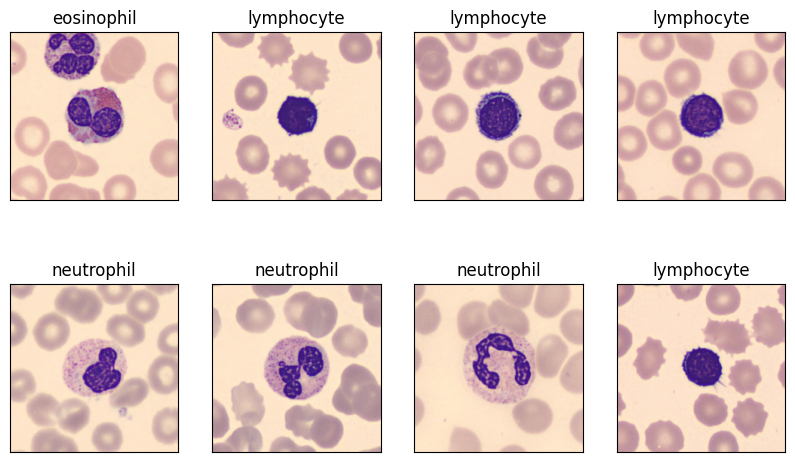

In [48]:
images, labels = next(iter(dataloaders['train']))
images = images.numpy()
fig = plt.figure(figsize=(10, 6))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((2, 1, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title("{}".format(class_names[labels[idx]]))

In [49]:
# Instantiate the model
net = torchvision.models.resnet34(weights=True)

# Display a summary of the layers of the model and output shape after each layer
summary(net,(images.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 112, 112]           9,408
       BatchNorm2d-2          [8, 64, 112, 112]             128
              ReLU-3          [8, 64, 112, 112]               0
         MaxPool2d-4            [8, 64, 56, 56]               0
            Conv2d-5            [8, 64, 56, 56]          36,864
       BatchNorm2d-6            [8, 64, 56, 56]             128
              ReLU-7            [8, 64, 56, 56]               0
            Conv2d-8            [8, 64, 56, 56]          36,864
       BatchNorm2d-9            [8, 64, 56, 56]             128
             ReLU-10            [8, 64, 56, 56]               0
       BasicBlock-11            [8, 64, 56, 56]               0
           Conv2d-12            [8, 64, 56, 56]          36,864
      BatchNorm2d-13            [8, 64, 56, 56]             128
             ReLU-14            [8, 64,

In [63]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=50):
    loss_over_time = [] # to track the loss as the network trains
    acc_over_time = []

    model = model.to(device) # Send model to GPU if available

    iter_num = {'train':0,'val':0} # Track total number of iterations

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

                # Iterate count of iterations
                iter_num[phase] += 1

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            loss_over_time.append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            acc_over_time.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    
    return loss_over_time, acc_over_time

In [65]:
# Instantiate the model
net = torchvision.models.resnet34(weights=True)

# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(net.parameters(), lr=0.1)
n_epochs= 50
n_batches = 20
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                        max_lr=0.5,
                                        base_momentum = 0.6,
                                        steps_per_epoch=n_batches,
                                        epochs=n_epochs)
lr_steps = []
mom_steps = []
for epoch in range(n_epochs):
    for batch in range(n_batches):
        optimizer.step()
        lr_steps.append(optimizer.param_groups[0]['lr'])
        mom_steps.append(optimizer.param_groups[0]['momentum'])
        scheduler.step()

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cost_path = train_model(net, criterion, optimizer, dataloaders, device, num_epochs=50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/49
----------
train Loss: 8.8477 Acc: 0.0024
val Loss: 8.5501 Acc: 0.0000
Epoch 1/49
----------
train Loss: 8.2418 Acc: 0.0024
val Loss: 7.7874 Acc: 0.0000
Epoch 2/49
----------
train Loss: 7.4767 Acc: 0.0072
val Loss: 7.3205 Acc: 0.0000
Epoch 3/49
----------
train Loss: 6.8006 Acc: 0.0288
val Loss: 6.5905 Acc: 0.0192
Epoch 4/49
----------
train Loss: 6.0586 Acc: 0.0529
val Loss: 5.9691 Acc: 0.0769
Epoch 5/49
----------
train Loss: 5.2764 Acc: 0.1538
val Loss: 5.0335 Acc: 0.1827
Epoch 6/49
----------
train Loss: 4.6835 Acc: 0.2188
val Loss: 4.2874 Acc: 0.2308
Epoch 7/49
----------
train Loss: 3.9599 Acc: 0.3005
val Loss: 3.6190 Acc: 0.3365
Epoch 8/49
----------
train Loss: 3.3177 Acc: 0.4495
val Loss: 3.1430 Acc: 0.4231
Epoch 9/49
----------
train Loss: 2.8290 Acc: 0.5361
val Loss: 2.6343 Acc: 0.5673
Epoch 10/49
----------
train Loss: 2.3354 Acc: 0.6490
val Loss: 2.1927 Acc: 0.6250
Epoch 11/49
----------
train Loss: 1.9685 Acc: 0.7043
val Loss: 1.8067 Acc: 0.6346
Epoch 12/49
--

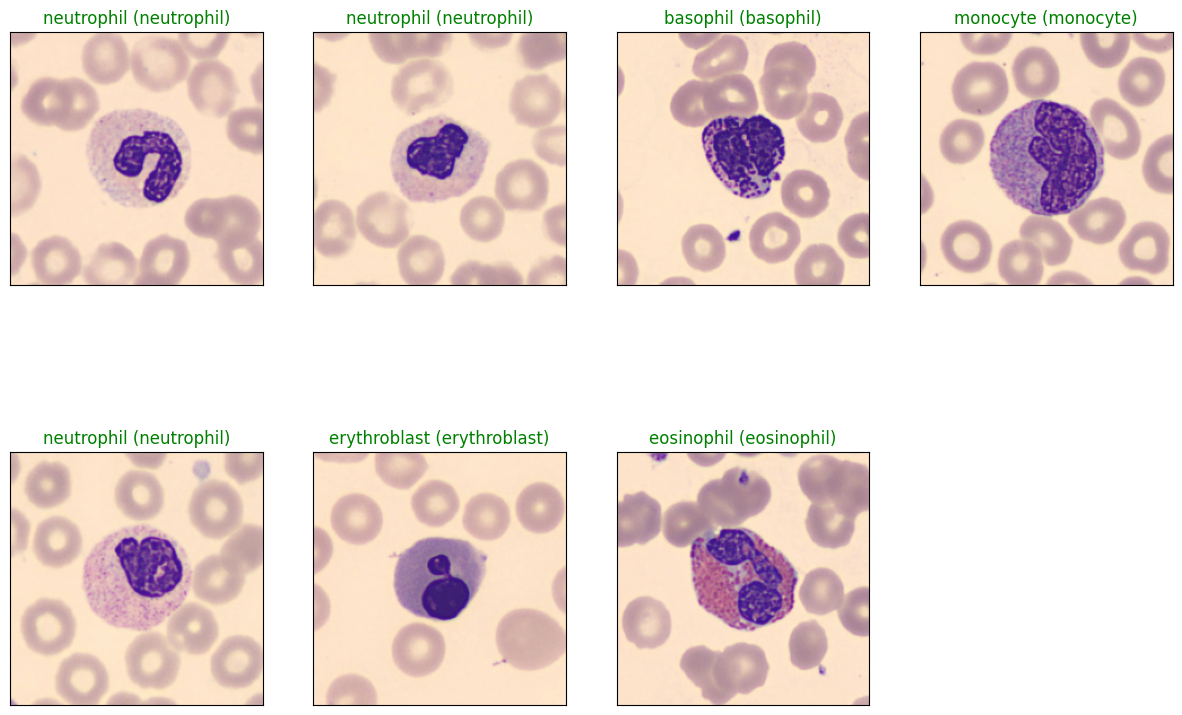

In [74]:
# Display a batch of predictions
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                            shuffle=False, num_workers=num_workers)
# Display a batch of predictions
def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = next(iter(val_loader))
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(7):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((2, 1, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(net,val_loader,device)

In [75]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=num_workers)
def test_model(model,test_loader,device):
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model = model.to(device)
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)
            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits,dim=1)
            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels.cpu().numpy())

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(7):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)
    
    return test_acc,recall_vals

In [76]:
# Calculate the test set accuracy and recall for each class
acc,recall_vals = test_model(net,test_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(7):
    print('For class {}, recall is {}'.format(class_names[i],recall_vals[i]))

Test set accuracy is 0.971
For class basophil, recall is 1.0
For class eosinophil, recall is 1.0
For class erythroblast, recall is 0.96
For class lymphocyte, recall is 0.8823529411764706
For class monocyte, recall is 0.96875
For class neutrophil, recall is 1.0
For class platelet, recall is 0.96875


In [77]:
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
filename = 'Resnet34_Onecyclelr.pt'

# Save the entire model
torch.save(net, os.path.join(model_dir,filename))